In [258]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import geopandas as gpd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
sns.set_style("darkgrid")

In [196]:
def plot_states(states: list, together=False, norm = 'none'):
    """
    norm == normalization factor
    
    if pop: per 100 K residents
    if density : divided by density
    if none: raw numbers
    
    """

    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv' 
    df_states = pd.read_csv(url)
    df_states['date'] = pd.to_datetime(df_states['date'])
    
    info = pd.read_csv("states_info.csv", 
                       usecols = ['ST', 'NAME', 'LD', 'Population','density','Governor', 'Party affiliation'],
                       index_col=['NAME']) 

    if not together:
        for state in states :

            pop = info.loc[state,'Population']


            df_copy = df_states[df_states['state'] == state].copy()
            df_copy['new_cases'] = np.diff(df_copy['cases'].values, prepend =0)
            df_copy['new_deaths'] = np.diff(df_copy['deaths'].values, prepend =0)

            fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(10,5), constrained_layout=True)
            fig.suptitle(f"{state}", size=20)
            formatter = mdates.DateFormatter("%m-%d")
            locator = mdates.MonthLocator()

            ax1.plot(df_copy['date'],df_copy['cases']*1e5/pop,'o-') 
            ax1.set_ylabel('cumulative cases \n per 100k residents')


            ax2.plot(df_copy['date'],df_copy['deaths']*1e5/pop,'^-')        
            ax2.set_ylabel('cumulative deaths \n per 100k residents')


            ax3.plot(df_copy['date'],df_copy['new_cases']*1e5/pop,'o-')
            ax3.plot(df_copy['date'], df_copy['new_cases'].rolling(7, win_type='gaussian').mean(std=3)*1e5/pop, 'k-')
            ax3.set_ylabel('daily cases \n per 100k residents')

            ax4.plot(df_copy['date'],df_copy['new_deaths']*1e5/pop,'^-')   
            ax4.plot(df_copy['date'], df_copy['new_deaths'].rolling(7, win_type='gaussian').mean(std=3)*1e5/pop, 'k-')
            ax4.set_ylabel('daily deaths \n per 100k residents')

            for ax in [ax1,ax2,ax3,ax4]:
                ax.set_xlabel('Date')
                ax.xaxis.set_major_formatter(formatter)
                ax.xaxis.set_major_locator(locator)
                ax.axvline(info.loc[state, 'LD'], color='k', alpha=0.2)

            #plt.savefig('/Users/NikhilStuff/Desktop/COVID19/figs/'+state+'.png',dpi =300)

            plt.show()
    else:
            
        fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,15), constrained_layout=True)
        formatter = mdates.DateFormatter("%m-%d")
        locator = mdates.MonthLocator()
        
        for state in states:
            pop = info.loc[state,'Population']
            density = info.loc[state,'density']
            
            if norm=='none':
                k = 1
                s=''
                
            elif norm=='pop':
                k = 1e5/pop
                s = 'per 100k residents'
            elif norm=='density':
                k = 1/density
                s =  '/ density'
                
            df_copy = df_states[df_states['state'] == state].copy()
            df_copy['new_cases'] = np.diff(df_copy['cases'].values, prepend =0)
            df_copy['new_deaths'] = np.diff(df_copy['deaths'].values, prepend =0)
            
            ax1.plot(df_copy['date'],df_copy['cases']*k,'-', label=state, lw=5) 
            ax2.plot(df_copy['date'],df_copy['deaths']*k,'-', label=state, lw=5)    
            ax3.plot(df_copy['date'], 
                     df_copy['new_cases'].rolling(7, win_type='gaussian').mean(std=5)*k, '-'
                     ,label=state, lw=5)
            ax4.plot(df_copy['date'], 
                     df_copy['new_deaths'].rolling(7, win_type='gaussian').mean(std=5)*k, '-'
                     ,label=state, lw=5)
#             for ax in [ax1,ax2,ax3,ax4]:
#                 ax.axvline(info.loc[state, 'LD'], color='k', alpha=0.2)
           
        
        ax1.set_ylabel(f'cumulative cases \n {s}', size=15)
        ax2.set_ylabel(f'cumulative deaths \n {s}', size=15)
        ax3.set_ylabel(f'daily cases \n {s}', size=15)
        ax4.set_ylabel(f'daily deaths \n {s}', size=15)
        
        ax1.set_title(f'cumulative cases \n {s}', size=15)
        ax2.set_title(f'cumulative deaths \n {s}', size=15)
        ax3.set_title(f'daily cases \n {s}', size=15)
        ax4.set_title(f'daily deaths \n {s}', size=15)
        
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_xlabel('Date', size=15)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(locator)
            ax.legend(ncol=2, fontsize='medium')
        

        
       

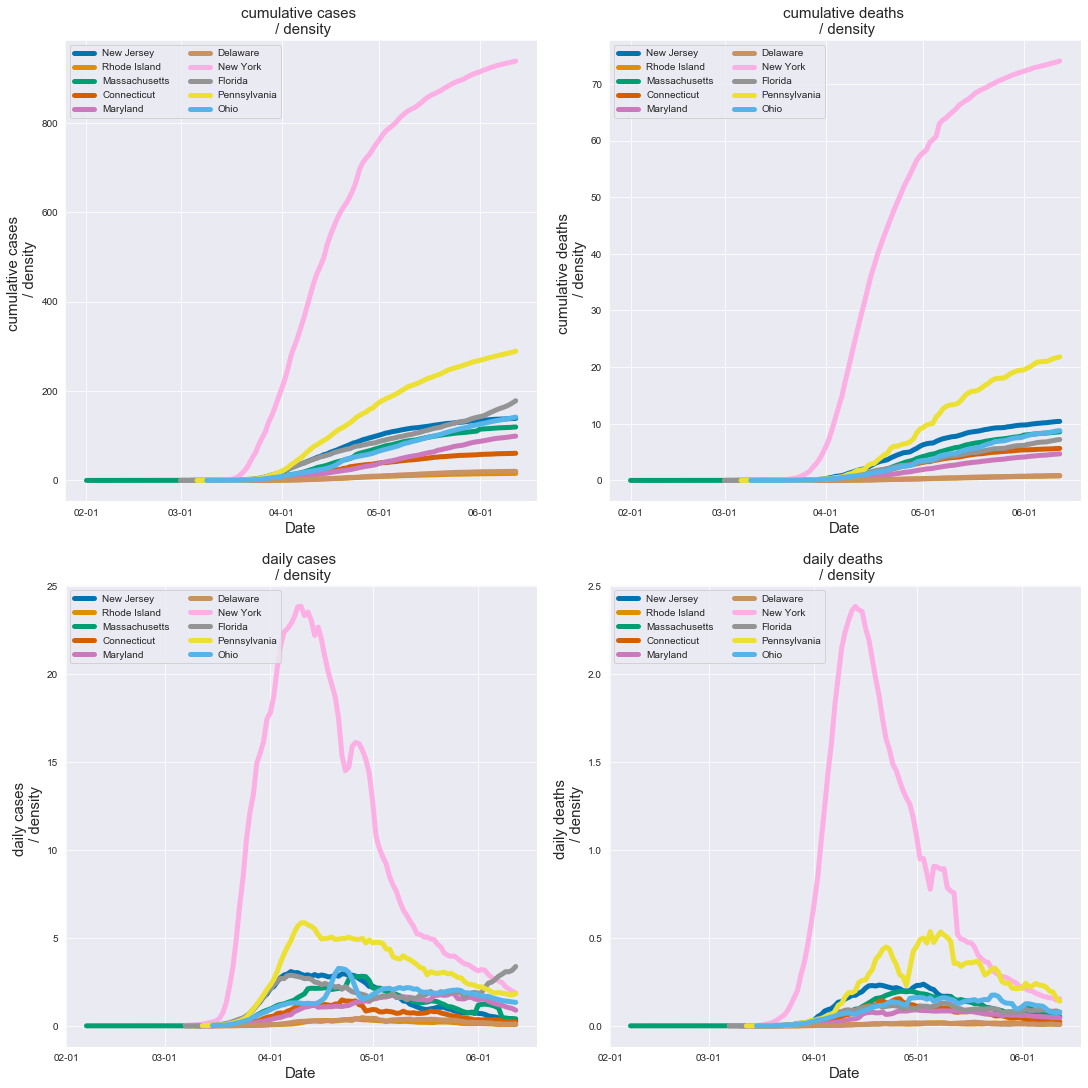

In [202]:
# plot_states(['Florida', 'California'], together=True)
plot_states(info['density'].sort_values(ascending=False)[:10].index.values, together=True, norm='density')

In [256]:
def plot_US(exclude=[]):

    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv' 
    df_states = pd.read_csv(url)
    df_states['date'] = pd.to_datetime(df_states['date'])
    
    y_cc  = df_states[~df_states['state'].isin(exclude)].groupby('date')['cases'].sum()
    y_cd = df_states[~df_states['state'].isin(exclude)].groupby('date')['deaths'].sum()
    
    y_nc = np.diff(y_cc.rolling(7, win_type='gaussian').mean(std=5).values, prepend =0)
    y_nd = np.diff(y_cd.rolling(7, win_type='gaussian').mean(std=5).values, prepend =0)

    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    formatter = mdates.DateFormatter("%m-%d")
    locator = mdates.MonthLocator()

    ax1.plot(y_cc.index, y_nc,'-')
    ax2.plot(y_cd.index, y_nd,'^')
    
    if len(exclude)==0:
        s=''
    else:
        s='\n excluding some states'

    ax1.set_title(f'daily cases in the US {s}')
    ax1.set_ylabel('daily cases')

    ax2.set_title(f'daily deaths in the US {s}')
    ax2.set_ylabel('daily deaths')
    for ax in [ax1,ax2]:
        ax.set_xlabel('Date')
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    plt.tight_layout()
    plt.show()

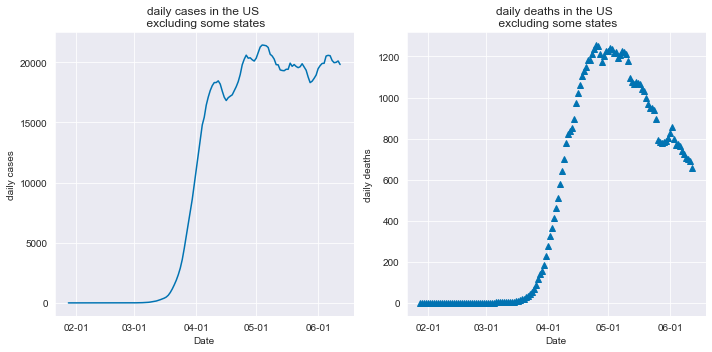

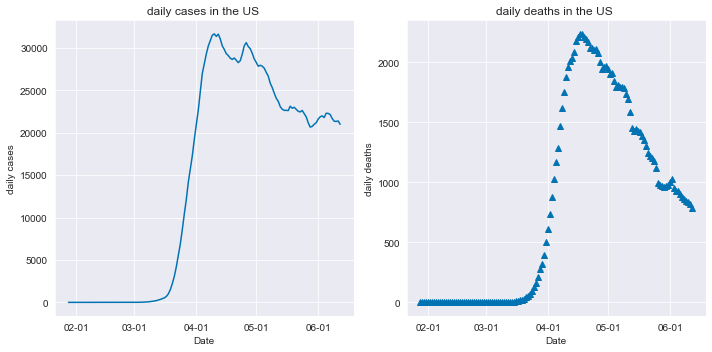

In [257]:
plot_US(exclude=['New York', 'New Jersey'])
plot_US(exclude=[])

In [452]:
def state_heatmap(state: str):
    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv' 

    df_counties = pd.read_csv(url)
    df_counties.date = pd.to_datetime(df_counties.date)
    df = df_counties[df_counties.state=='New Jersey'].groupby(['date', 'county'])['cases'].sum()
    
    shapefile = gpd.read_file('/Users/NikhilStuff/Desktop/COVID19/New_Jersey_Counties/New_Jersey_Counties.shp')
    shapefile['diff_cases'] = pd.Series(np.zeros(len(shapefile)))
    

    X_list =  shapefile.centroid.geometry.x
    Y_list =  shapefile.centroid.geometry.y
    county_list = shapefile.COUNTY.str.title().values
    
    dates = pd.unique(df_counties[df_counties.state=='New Jersey']['date'])
    for i in range(1, len(dates)): 
        
        df_date = pd.merge(pd.DataFrame(index=county_list),
                           df.loc[dates[i]].to_frame(), 
                           how='left', left_index=True, right_index=True)
        df_date.fillna(0, inplace=True)
        
        
        df_yesterday = pd.merge(pd.DataFrame(index=county_list),
                           df.loc[dates[i-1]].to_frame(), 
                           how='left', left_index=True, right_index=True)
        df_yesterday.fillna(0, inplace=True)
        
        

        shapefile['diff_cases'] = pd.Series(df_date['cases'].values - df_yesterday['cases'].values)
        

        
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        shapefile.plot(column = 'diff_cases', cmap = 'hot',legend = True, ax = ax, vmin=-100, vmax=900)
        for x,y,county in zip(X_list,Y_list,county_list):
            plt.text(x,y,county, fontsize = 5, color = 'white')
        ax.grid([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(dates[i])[:10])
#         plt.savefig(f"/Users/NikhilStuff/Desktop/COVID19/figs/heatmaps/{str(dates[i])[:10]}.png", dpi=300)
#         plt.close()
#         plt.show()
       
    
    

In [453]:
state_heatmap('New Jersey')